# Time series forecasting and BitPredict

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub
import shutil


## Get Data


In [3]:
# !curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [4]:
dataset = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
dataset.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
bitcoin_prices = pd.DataFrame(dataset["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


<Axes: title={'center': 'Bitcoin Price History'}, xlabel='Date', ylabel='Price'>

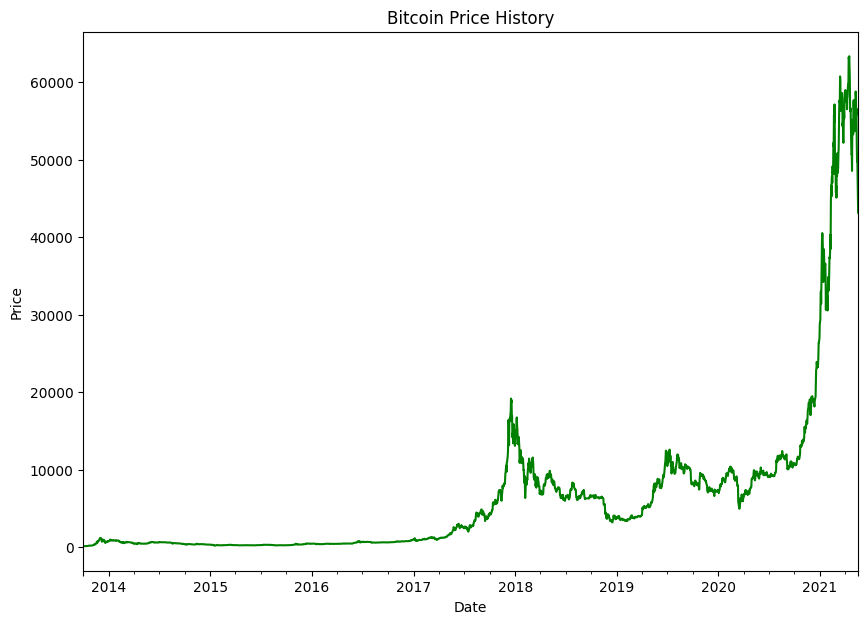

In [7]:
bitcoin_prices.plot(
    figsize=(10, 7),
    title="Bitcoin Price History",
    xlabel="Date",
    ylabel="Price",
    legend=False,
    color="green",    
)

In [8]:
split_size = int(0.8 * len(bitcoin_prices))

X_train, y_train = bitcoin_prices.index[:split_size].to_numpy(), bitcoin_prices.Price[:split_size].to_numpy()
X_test, y_test = bitcoin_prices.index[split_size:].to_numpy(), bitcoin_prices.Price[split_size:].to_numpy()

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

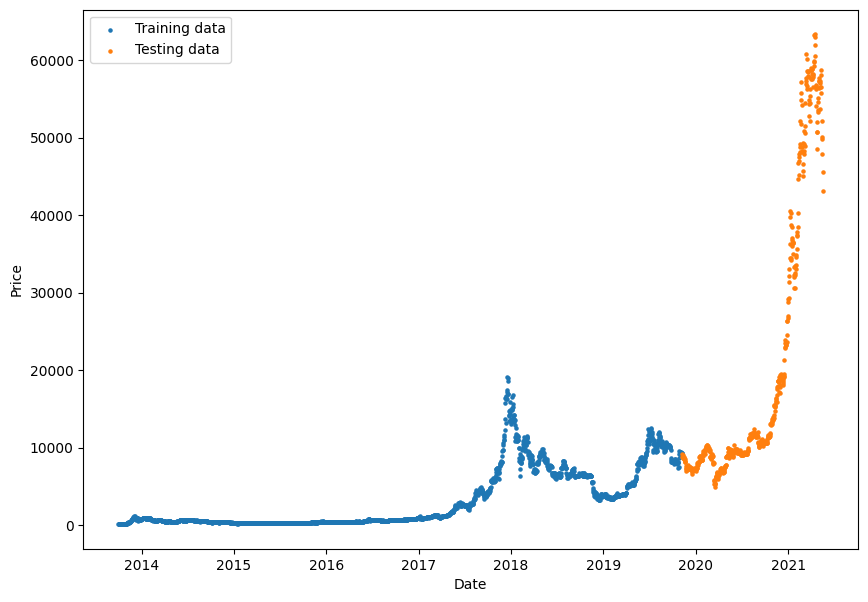

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Training data")
plt.scatter(X_test, y_test, s=5, label="Testing data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show();

In [10]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

In [11]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Returns the mean absolute scaled error between y_true and y_pred.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
    """
    Performs various evaluation comparison on y_true labels vs. y_pred labels.

    Parameters
    ----------
    y_true : array of true labels
    y_pred : array of predicted labels

    Returns a dictionary of different evaluation metrics.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    # Account for zero division
    # if mae.numpy() == 0:
    #     mase = 0
    # else:
    #     mase = mase.numpy()
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
        
    # Create dictionary of metrics
    metrics = {"mae": mae.numpy(),
               "mse": mse.numpy(),
               "rmse": rmse.numpy(),
               "mape": mape.numpy(),
               "mase": mase}
    return metrics

In [12]:
HORIZON = 1
WINDOW_SIZE = 7

In [13]:
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [14]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    # print(f"Window indexes:\n {window_indexes}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(f"Target time series:\n {x}")
    # print(f"Target time series Shape: {x.shape}")
    
    # print(f"Windowed time series:\n {windowed_array}")
    # print(f"Windowed time series Shape: {windowed_array.shape}")

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [15]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    Returns two tuples of (windows, labels) train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

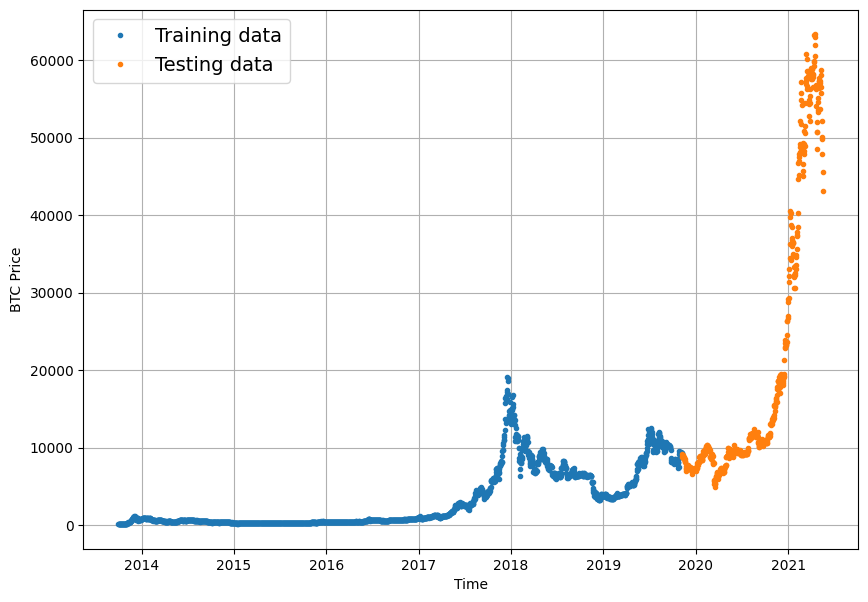

In [16]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Training data")
plot_time_series(timesteps=X_test, values=y_test, label="Testing data")


## Modeling

### Model 0: Naive forecast (baseline)

In [17]:
naive_forecast = y_test[:-1]

naive_forecast[:10], y_test[:10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

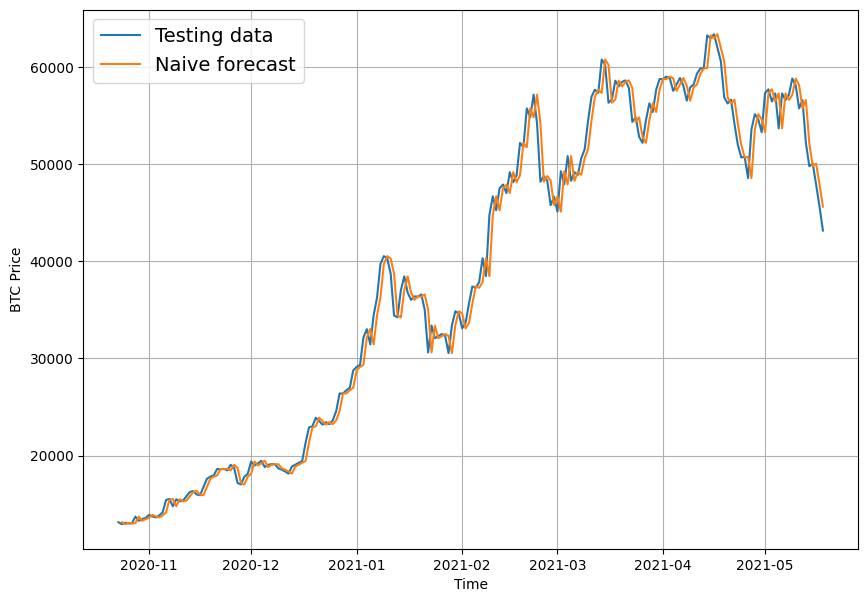

In [18]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Testing data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")


In [19]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast)

2024-01-26 18:01:15.762853: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-26 18:01:15.762872: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-26 18:01:15.762883: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-26 18:01:15.762927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-26 18:01:15.762961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182626>

In [20]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.1,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.99957>}

### Windowing for 1 week

In [21]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()}\nLabel: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6]
Label: 7


In [22]:
full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy())

In [23]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Making Callbacks

In [25]:
def get_callbacks(experiment_name, use_early_stopping = False, patience=3):
    if use_early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_mae",
            patience=patience,
            restore_best_weights=True,
        )
    callbacks = [
        create_tensorboard_callback(
            dir_name="bit_predict/tensorboard",
            experiment_name=experiment_name,
        ),
        create_checkpoint_callback(
            dir_name="bit_predict/checkpoint",
            experiment_name=experiment_name,
            monitor="val_mae",
            
            
        ),
    ]
    if use_early_stopping:
        callbacks.append(early_stopping)
    return callbacks

<input type="checkbox" id="vehicle1" name="vehicle1" checked>
<label for="vehicle1"> Model 1 = 30 min</label><br>

<input type="checkbox" id="vehicle2" name="vehicle2" checked>
<label for="vehicle2"> Model 2 = 18 min</label><br>

<input type="checkbox" id="vehicle3" name="vehicle3" checked>
<label for="vehicle3"> Model 3 = 40 min</label><br>

<input type="checkbox" id="vehicle4" name="vehicle4">
<label for="vehicle4"> Model 4 = 30 min</label><br>

<input type="checkbox" id="vehicle5" name="vehicle5">
<label for="vehicle5"> Model 5 = 15 min</label><br>

<input type="checkbox" id="vehicle6" name="vehicle6">
<label for="vehicle6"> Model 6 = 50 min</label><br>

<input type="checkbox" id="vehicle7" name="vehicle7">
<label for="vehicle7"> Model 7 = 120 min</label><br>

<input type="checkbox" id="vehicle8" name="vehicle8">
<label for="vehicle8"> Model 8 = 100 min</label><br>

<input type="checkbox" id="vehicle9" name="vehicle9">
<label for="vehicle9"> Model 9 = 40 min</label><br>

<input type="checkbox" id="vehicle10" name="vehicle10">
<label for="vehicle10"> Model 10 = 30 min</label><br>


### Model 1: Dense Model (window = 7, horizon = 1)

In [26]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_1.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_1 = model_1.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_1"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_1/20240126-180116
Saving model checkpoints to: bit_predict/checkpoint/model_1/checkpoint.ckpt
Epoch 1/100


2024-01-26 18:01:16.437217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 24ms/step - loss: 288.6049 - mae: 288.6049 - mse: 341328.7188 - val_loss: 887.6348 - val_mae: 887.6348 - val_mse: 2561368.7500
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 188.3131 - mae: 188.3131 - mse: 180168.9688 - val_loss: 895.1041 - val_mae: 895.1041 - val_mse: 2640316.2500
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 162.7575 - mae: 162.7575 - mse: 140236.4062 - val_loss: 978.3856 - val_mae: 978.3856 - val_mse: 2764904.2500
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 165.6243 - mae: 165.6243 - mse: 143057.9531 - val_loss: 885.4014 - val_mae: 885.4014 - val_mse: 2430196.5000
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 154.3441 - mae: 154.3441 - mse: 131147.2188 - val_loss: 848.9039 - val_mae: 848.9038 - val_mse: 2296224.2500
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 155.1865 - mae: 155.1865 - m

In [27]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 16ms/step - loss: 582.4276 - mae: 582.4276 - mse: 1185411.6250


[582.4276123046875, 582.4276123046875, 1185411.625]

In [28]:
model_1.load_weights("bit_predict/checkpoint/model_1/checkpoint.ckpt")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.4620 - mae: 568.4620 - mse: 1161542.5000


[568.4619750976562, 568.4619750976562, 1161542.5]

In [29]:
model_1_results1 = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_1.predict(test_windows)))
model_1_results1

18/18 [==============================] - 0s 1ms/step


{'mae': 568.46204,
 'mse': 1161542.5,
 'rmse': 1077.7488,
 'mape': 2.5156543,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.9986302>}

18/18 [==============================] - 0s 1ms/step


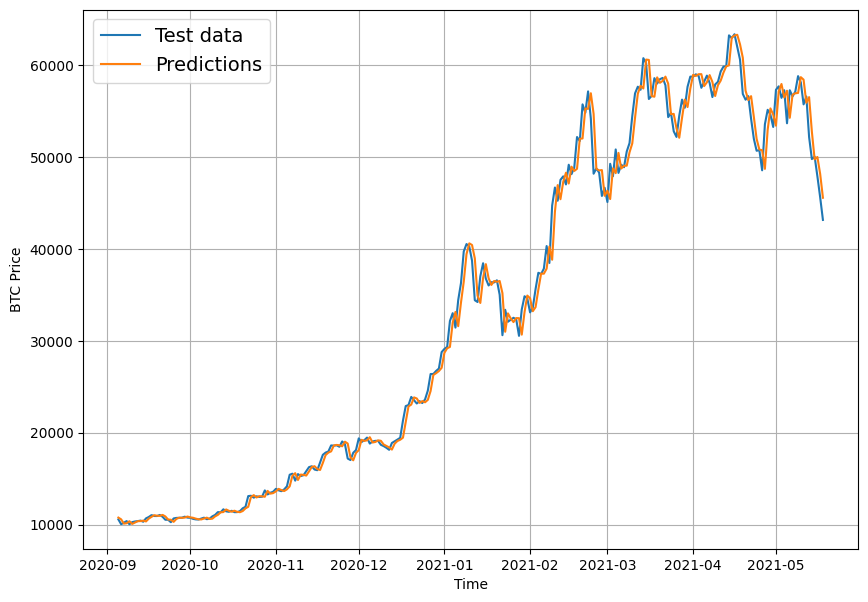

In [30]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_1.predict(test_windows)[:, 0], start=offset, format="-", label="Predictions")


### Model 2: Dense (window = 30, horizon = 1)

In [31]:
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [32]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [33]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_2.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_2 = model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_2"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_2/20240126-180131
Saving model checkpoints to: bit_predict/checkpoint/model_2/checkpoint.ckpt


In [34]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 13ms/step - loss: 668.1670 - mae: 668.1670 - mse: 1420842.1250


[668.1669921875, 668.1669921875, 1420842.125]

In [35]:
model_2.load_weights("bit_predict/checkpoint/model_2/checkpoint.ckpt")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 607.1243 - mae: 607.1243 - mse: 1270121.7500


[607.1243286132812, 607.1243286132812, 1270121.75]

In [36]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_2.predict(test_windows)))
model_2_results

18/18 [==============================] - 0s 2ms/step


{'mae': 607.1243,
 'mse': 1270121.8,
 'rmse': 1126.9968,
 'mape': 2.7634428,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=1.0612593>}

18/18 [==============================] - 0s 1ms/step


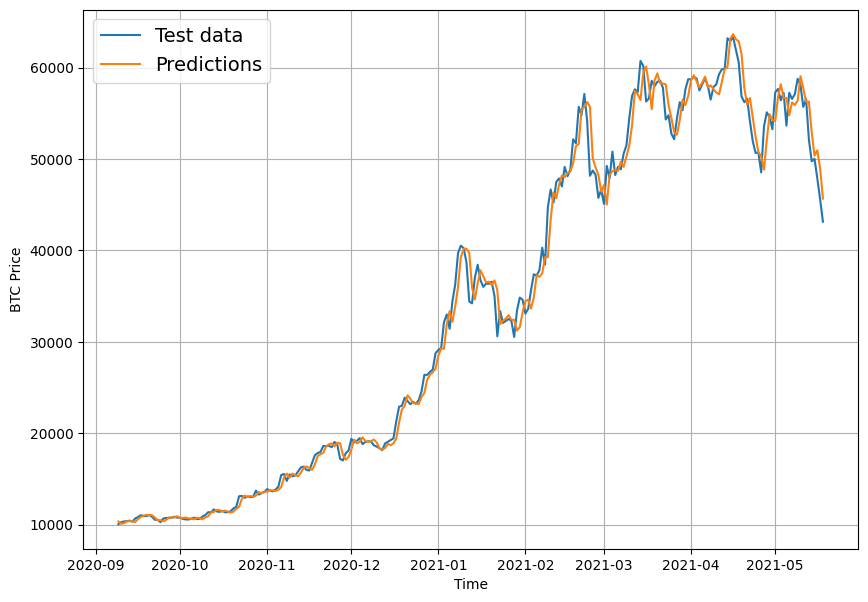

In [37]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_2.predict(test_windows)[:, 0], start=offset, format="-", label="Predictions")

### Model 3: Dense (window = 30, horizon = 7)

In [38]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [39]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [40]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_3.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_3 = model_3.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_3"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_3/20240126-180143
Saving model checkpoints to: bit_predict/checkpoint/model_3/checkpoint.ckpt


In [41]:
model_3.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 14ms/step - loss: 1272.6631 - mae: 1272.6631 - mse: 5436846.5000


[1272.6630859375, 1272.6630859375, 5436846.5]

In [42]:
model_3.load_weights("bit_predict/checkpoint/model_3/checkpoint.ckpt")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1228.0167 - mae: 1228.0167 - mse: 5285314.5000


[1228.0167236328125, 1228.0167236328125, 5285314.5]

In [43]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_3.predict(test_windows)))
model_3_results


18/18 [==============================] - 0s 2ms/step


{'mae': 1228.0167,
 'mse': 5285314.5,
 'rmse': 1424.1127,
 'mape': 5.635548,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=2.1851869>}

18/18 [==============================] - 0s 3ms/step


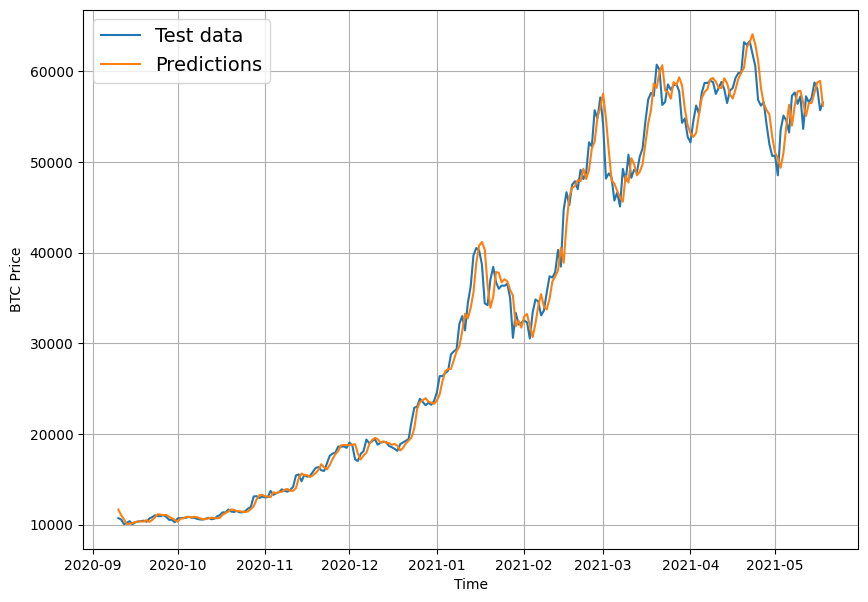

In [50]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_3.predict(test_windows)[:, 0], start=offset, format="-", label="Predictions")

18/18 [==============================] - 0s 2ms/step


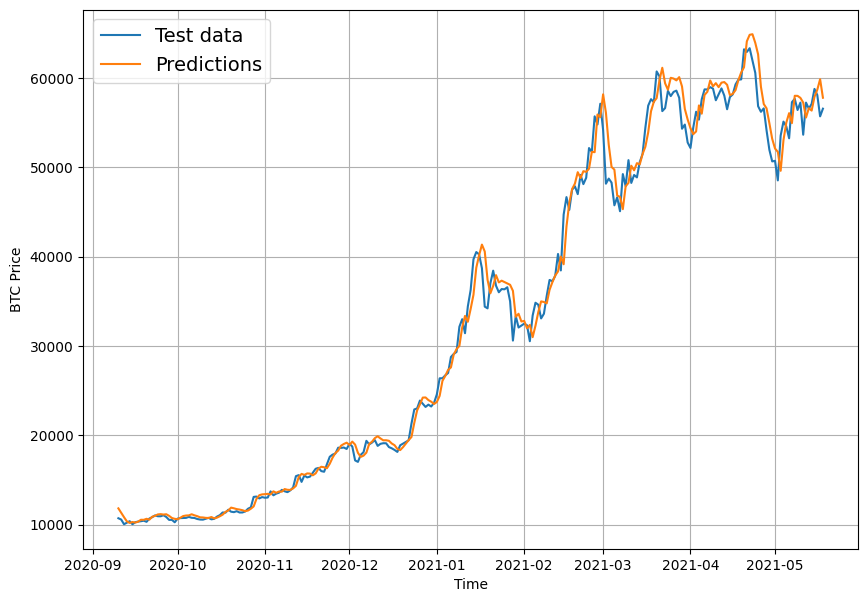

In [46]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=tf.reduce_mean(model_3.predict(test_windows), axis=1), start=offset, format="-", label="Predictions")